# Numerical simulation (annealing time)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from QUBO import QMatrix, QUBOSolution
from qutip import *
import networkx as nx
import itertools
from scipy import interpolate
from graphs import DrawSolution, NetworkToFile, FileToNetwork
from graphs import DrawNetwork, GraphPartitioning, RandomGraphGenerator

We want to simulate the annealing path 

$$H(s) = -\frac{A(s)}{2} H_I + \frac{B(s)}{2} H_{P}$$

with 

$$H_I = \sum_i \sigma_i^x$$

and 

$$H_{P} = \sum_i h_i \sigma_i^z + \sum_{i<j} J_{ij} \sigma_i^z \sigma_j^z$$

Since we have developed most of the examples using the QUBO formulation, we will stick to that. Therefore, the problem Hamiltonian will be given by 

$$H_p(x) = \sum_i Q_{ii} x_i + \sum_{i < j} Q_{ij} x_i x_j \quad x_i \in \{0,1\}$$

where Q is the matrix calculated for the GP problem.

## Functions

In [2]:
#Initial Hamiltonian
def makeInitialHamiltonian(N):
    '''
    Returns the initial Hamiltonian

    Parameters
    ----------
    N  : int
         dimension of the graph
                
    Output
    ------
    Hi  :  array
           initial Hamiltonian
    '''
            
    sx = sigmax()
    identity = qeye(2)
    
    sx_list = []
    
    for n in range(N):
        aux_list = []
        for m in range(N):
            aux_list.append(identity)
    
        aux_list[n] = sx
        sx_list.append(tensor(aux_list))
    
    Hi = 0
    for item in sx_list:
        Hi += item
    
    return np.array(-Hi)

In [3]:
#QUBO Hamiltonian
def makeQUBOHamiltonian(fileName, alpha, beta):
    '''
    Returns the QUBO problem Hamiltonian for a given graph

    Parameters
    ----------
    fileName  : string
                name of the file containing the graph
    alpha     : double
                weight balancing constraint for the Q matrix
    beta      : double
                weight balancing constraint for the Q matrix
                
    Output
    ------
    Hp  :  array
           QUBO problem Hamiltonian
    '''
    
    #Computing the Q matrix
    Q = QMatrix(fileName, alpha, beta)
    
    #Hamiltonian
    dim = pow(2, len(Q))
    H = np.zeros(dim)
    Hp = np.zeros((dim, dim), dtype=complex)
    
    state = [0 for i in range(len(Q))]
      
    #for k in range(dim):
        #for i in range(len(Q)):
            #H[k] += Q[i][i]*state[i]
        #for j in range(i):
            #H[k] += Q[i][j]*state[i]*state[j]
    
        #nextState(state)
    for k in range(dim):
        H[k] = np.matmul(state, np.matmul(Q, state))
        nextState(state)
        
    for k in range(dim):
        Hp[k][k] = H[k]
        
    return H, Hp  

In [4]:
def nextState(state):
    '''
    Modifies a given QUBO state into a new one
    
    Parameters
    ----------
    state  : array
             state of the QUBO Hamiltonian
    '''
    
    n = len(state) - 1
    aux = False
    
    while not (aux):
        
        if (state[n] == 0):
            aux = True
            break
        
        n -= 1
        if (n < 0):
            break
    
    state[n] = 1
    n += 1
    while (n < len(state)):
        state[n] = 0
        n +=1

In [5]:
def groundState(H):
    '''
    Computes the ground states of a given diagonal Hamiltonian
    
    Parameters
    ----------
    H  : array
         given Hamiltonian
         
    Output
    ------
    gs  : list
          position of the ground states
          
    '''
    
    aux = H[0]
    
    for i in range(len(H)):
        if(H[i] < aux):
            aux = H[i]
    
    gs = []
    
    for i in range(len(H)):
        if (np.absolute(H[i]-aux) < 0.001):
            gs.append(i)
        
    return gs

In [6]:
def path(fileName):
    '''
    Returns the annealing path functions
    
    Parameters
    ----------
    fileName  : string
                name of the file containing the functions
    
    Output
    ------
    A  : array
         values of A(s)
    B  : array
         values of B(s)
    '''
    
    vecA = np.zeros(1000)
    vecB = np.zeros(1000)
    s = np.zeros(1000)
    i = 0
    
    with open(fileName) as file:
        for line in file:
            info =  line.split()
            s[i] = float(info[0])
            vecA[i] = np.pi*float(info[1])
            vecB[i] = np.pi*float(info[2])
            i +=1
            
    A = interpolate.interp1d(s, vecA, kind = "quadratic")
    B = interpolate.interp1d(s, vecB, kind = "quadratic")
    
    return A, B

In [7]:
def spectraEvolution(Hi, Hp, A, B, divisions, num_bands, gs):
    '''
    Calculates the evolution of the energy for a given number of states
    
    Parameters
    ----------
    Hi         : array
                 initial Hamiltonian
    Hp         : array
                 problem Hamiltonian
    A          : interpolate function
    B          : interpolate function
    
    divisions  : int
                 number of steps s
                 
    num_bands  : int
                 number of states to study
    gs         : int
                 ground states of Hp

    Output
    ------
    gap    : float
             value of the energy gap
    evals  : array
             energy values
    '''
    
    degeneracy = len(gs)
    gap = 1e100
    s = np.linspace(0, 1, divisions)
    evals = np.zeros((num_bands, divisions))
    
    for i, ts in enumerate(s):
        w = np.linalg.eigvalsh(A(ts)*Hi + B(ts)*Hp)
        
        for j in range(num_bands):
            evals[j][i] = w[j]
            
        if (gap > (w[degeneracy] - w[0])):
            gap = w[degeneracy] - w[0]
    
    return gap, evals

In [8]:
def CrankNicolson(H, psi, delta_t):
    '''
    Crank-Nicolson algorithm for the time evolution of the wavefunction

    Input
    -----
    H        : array
               Hamiltonian of the system
    psi      : array
               wave function at t
    delta_t  : double
               time increase
    
    Output
    ------
    psi  : array
           wave function at t + delta_t
    '''
    dim = len(H)
    
    M = np.identity(dim, dtype=complex) - (0. + 1.j)*delta_t/2*H
    Minv = np.linalg.inv(np.identity(dim, dtype=complex) + (0. + 1.j)*delta_t/2*H)
    
    psi = np.matmul(M, psi)
    psi = np.matmul(Minv, psi)
    
    return psi

In [9]:
def evolutionAB_IG(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the evolution of the system and the overlap with instantaneous ground state 
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : list
               overlap with instantaneous ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(A(t/tf)*Hi + B(t/tf)*Hp)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = vep[:,i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        vap, vep = np.linalg.eigh(H)
        mod = 0
            
        for j in range(degeneracy):
            psi0 = vep[:, j]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

In [10]:
def evolutionABTarget(Hi, Hp, A, B, tf, delta_t, gs):
    '''
    Calculates the evolution of the system and the overlap with target ground state 
    

    Input
    -----
    Hi          : array
                  initial Hamiltonian
    Hp          : array
                  problem Hamiltonian
    A           : interpolate function
    B           : interpolate function
    tf          : float
                  maximum annealing time
    delta_t     : double
                  time increase
    Output
    ------
    overlap  : list
               overlap with target ground state
    '''
    
    overlap = []
    t = 0
    degeneracy = len(gs)
    
    vap, vep = np.linalg.eigh(Hp)
    psi_target = []
    for i in range(degeneracy):
        psi_target.append(vep[:, i])
    
    H = A(t/tf)*Hi + B(t/tf)*Hp
    
    vap, vep = np.linalg.eigh(H)
    mod = 0
    psi = vep[:,0]
    
    for i in range(degeneracy):
        psi0 = psi_target[i]
        psi0 = np.conjugate(psi0)
        prod = np.dot(psi,psi0)
        mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
    
    overlap.append(mod)
        
    while (t < tf):
        
        H = A(t/tf)*Hi + B(t/tf)*Hp
            
        psi = CrankNicolson(H, psi, delta_t)
        t += delta_t
            
        mod = 0
            
        for j in range(degeneracy):
            psi0 = psi_target[i]
            psi0 = np.conjugate(psi0)
            prod = np.dot(psi,psi0)
            mod += (np.real(prod)*np.real(prod) + np.imag(prod)*np.imag(prod))
            
        overlap.append(mod)
    
    return overlap

## Simulation for a given graph

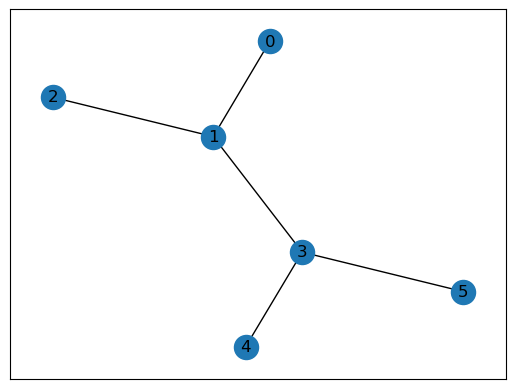

In [11]:
#Create the graph
G = FileToNetwork("1.txt")
DrawNetwork(G, "1.png")

In [12]:
#Parameters
min_tf = 0.5
max_tf = 6.5
num_tf = 10
tf = np.linspace(min_tf, max_tf, num_tf)
delta_t = 0.001
print(tf)

[0.5        1.16666667 1.83333333 2.5        3.16666667 3.83333333
 4.5        5.16666667 5.83333333 6.5       ]


In [13]:
#Functions
A, B = path("DW_2000Q_6.txt")

In [14]:
#Hamiltonians
Hi = makeInitialHamiltonian(len(list(G.nodes)))
Hp1, Hp2 = makeQUBOHamiltonian("1.txt", 1.25, 1)
gs = groundState(Hp1)
num_eigenstates = 3
dim = len(Hi)
print(gs)

[7, 56]


In [15]:
#Evolution of the energy
gap, energies = spectraEvolution(Hi, Hp2, A, B, 100, num_eigenstates, gs)
print(gap)

9.817624243925323


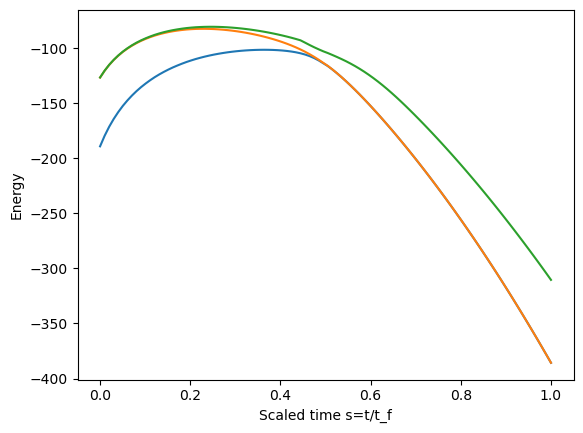

In [16]:
for i in range(num_eigenstates):
    plt.xlabel("Scaled time s=t/t_f")
    plt.ylabel("Energy")
    plt.plot(np.linspace(0,1,100), energies[i])

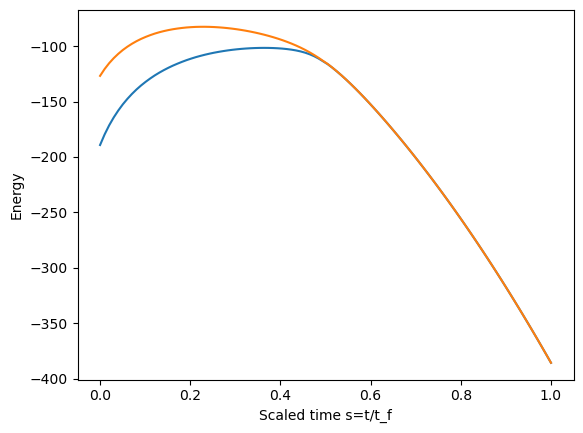

In [17]:
for i in range(len(gs)):
    plt.xlabel("Scaled time s=t/t_f")
    plt.ylabel("Energy")
    plt.plot(np.linspace(0,1,100), energies[i])

In [18]:
#Overlap (instantaneous ground state)
overlap_IG = []
for i in range(num_tf):
    overlap_IG.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_IG[i].append(evolutionAB_IG(Hi, Hp2, A, B, t_f, delta_t, gs)) 

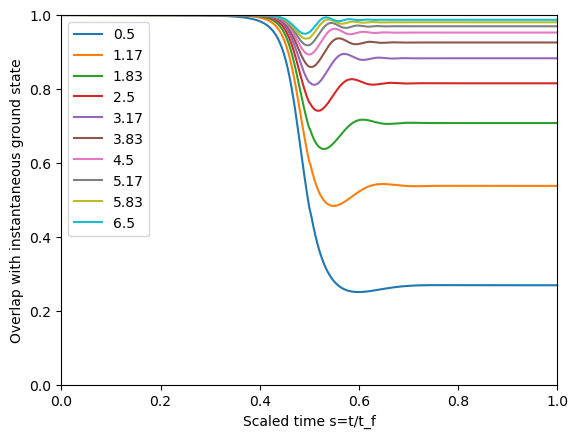

In [19]:
#Plot overlap with instantaneous ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with instantaneous ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_IG[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_IG[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_IG_6.png")

In [ ]:
#Overlap (target ground state)
overlap_TG = []
for i in range(num_tf):
    overlap_TG.append([])
    
for i in range(num_tf):
    
    t_f = tf[i]
    
    #Evolution
    overlap_TG[i].append(evolutionABTarget(Hi, Hp2, A, B, t_f, delta_t, gs)) 

In [ ]:
#Plot overlap with target ground state
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Scaled time s=t/t_f")
plt.ylabel("Overlap with target ground state")
for i in range(num_tf):
    x = np.linspace(0, 1, len(overlap_TG[i][0]))
    name = str(round(tf[i],2))
    plt.plot(x, overlap_TG[i][0], label = name)
    plt.legend()
plt.savefig("Overlap_TG_6.png")

In [ ]:
def checkResults(overlap1, overlap2, num_tf):
    results = []
    
    for i in range(num_tf):
        results.append(overlap1[i][0][-1]-overlap2[i][0][-1])
    return results           

In [ ]:
print(checkResults(overlap_IG, overlap_TG, num_tf))

In [ ]:
plt.xlim([min(tf), max(tf)])
plt.ylim([0, 1])
plt.xlabel("Annealing time (ns)")
plt.ylabel("Overlap (Success Probability)")
successProbability = np.empty(num_tf)
for i in range(num_tf):
    successProbability[i] = overlap_TG[i][0][-1]
plt.plot(tf, successProbability)
plt.savefig("Success_Probability_vs_Annealing_time_6")